# Step 3
- Determine the topics in the conversations of chosen characters

In [1]:
import pandas as pd
import numpy as np
import gensim
from gensim import corpora
from gensim.parsing.preprocessing import remove_stopwords
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
# nltk.download('averaged_perceptron_tagger')

In [2]:
sheets = ['episode1', 'episode2', 'episode3', 'episode4', 'episode5', 'episode6']
data = pd.concat([pd.read_excel('data.xlsx', sheet_name = sheet) for sheet in sheets])

In [3]:
df = (data
     .assign(dialogue=lambda df_: df_.dialogue.str.replace('\s+', ' ', regex=True).str.strip())
     .assign(sorted_pairs=lambda df_: df_.apply(lambda df_: '-'.join(sorted([df_['initiator'], df_['responder']])), axis=1))
     .assign(weight=lambda df_: df_.groupby(['sorted_pairs'])['sorted_pairs'].transform('count'))
     .assign(dialogue=lambda df_: df_.groupby(['sorted_pairs'])['dialogue'].transform(lambda df_: ' '.join(df_.unique())))
     .drop_duplicates('sorted_pairs')
     .drop(columns='sorted_pairs')
    )

In [4]:
# func to add topics
def add_topic_labels(df):
    # create a list of documents from the 'dialogue' column
    documents = list(df['dialogue'])

    # define stop words, tags to remove, and words to remove
    stop_words = stopwords.words('english')
    removal = ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'NUM', 'SYM']
    remove_words = ['like', 'gone', 'know', 'right', 'na', 'gon', 'yeah', 'really', 'okay',
                    'get', 'gonna', 'well', 'thank', 'oh', 'uh', 'hi', 'got', 'um', 'go',
                    'would', 'great', 'come', 'hey', 'wanna', 'hmm', 'mr', 'yes', 'good']

    # remove stop words and unwanted words
    tokenized_docs = [[token for token in gensim.utils.simple_preprocess(doc) if token not in stop_words and token not in remove_words] for doc in documents]

    # remove tags
    tagged_docs = [nltk.pos_tag(doc) for doc in tokenized_docs]
    tokenized_docs = [[token for token, pos in doc if pos not in removal] for doc in tagged_docs]

    # create a dictionary from the tokenized documents
    dictionary = corpora.Dictionary(tokenized_docs)

    # create a bag-of-words representation of the documents
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]

    # train an LDA model on the corpus
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics=5,
                                                random_state=42,
                                                passes=10)

    # extract the top fifteen words for each topic
    topic_labels = []
    for doc in tokenized_docs:
        bow = dictionary.doc2bow(doc)
        topics = lda_model.get_document_topics(bow)
        top_fifteen_words = [dictionary[word] for word, prob in sorted(lda_model.get_topic_terms(max(topics, key=lambda x: x[1])[0], topn=15), key=lambda x: x[1], reverse=True)]
        topic_labels.append(top_fifteen_words)

    # add the topic labels as a new column in the dataframe
    df['topic'] = topic_labels
    return df

In [5]:
# Define the names to create DataFrames for
chosen_names = ['NICOLE', 'TANYA', 'RACHEL', 'SHANE', 'ARMOND', 'PAULA', 'OLIVIA']

# Loop through the chosen names and create a new DataFrame for each one
for name in chosen_names:
    # Select rows where the name appears in either initiator or responder
    new_df = df[(df['initiator'] == name) | (df['responder'] == name)]
    
    # Create a new DataFrame with the selected rows
    globals()[f'{name}_df'] = pd.DataFrame(new_df)

In [6]:
# func to add word_count column
def tweak_df(df):
    return (df
             .assign(word_count=lambda df_: df_.dialogue.str.len().astype('int16'))
             .astype({'weight': 'int8'})
             .sort_values('word_count', ascending=False)
             .reset_index()
             .drop(columns='index')
            )

# list of dataframes to tweak
tweak_these = [NICOLE_df, TANYA_df, RACHEL_df, SHANE_df, ARMOND_df, PAULA_df, OLIVIA_df]

for i in range(len(tweak_these)):
    tweak_these[i] = tweak_df(tweak_these[i])

NICOLE_df, TANYA_df, RACHEL_df, SHANE_df, ARMOND_df, PAULA_df, OLIVIA_df = tweak_these


# list of dataframes to add topics to
topic_df = [NICOLE_df, TANYA_df, RACHEL_df, SHANE_df, ARMOND_df, PAULA_df, OLIVIA_df]

for i in range(len(topic_df)):
    topic_df[i] = add_topic_labels(topic_df[i])

NICOLE_df, TANYA_df, RACHEL_df, SHANE_df, ARMOND_df, PAULA_df, OLIVIA_df = topic_df

## Topic conversations of interesting characters

In [7]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams


# SET VIZ TEMPLATE
# colors
YELLOW='yellow'
BLACK='#1a1a1a'
GREY='#696969'
WHITE='white'

# fonts
futura_font_path = 'graphfonts/Futura/futura-medium-condensed.ttf'
FUTURA = fm.FontProperties(fname=futura_font_path)

paypal_font_path = 'graphfonts/Paypal/PayPalSansSmall-Regular.ttf'
PAYPAL = fm.FontProperties(fname=paypal_font_path)

DPI=200

#func to plot topics
def plot_word_grid(words, suptitle):
    # Define the figure size and background color
    fig = plt.figure(figsize=(8, 4), facecolor=BLACK, dpi=DPI)

    # Set the title
    fig.suptitle(suptitle, fontproperties=FUTURA, color='white', fontsize=12, y=.93)

    # Define the layout of the subplots
    layout = (5, 5)

    # Create subplots and add words to them
    for i, word in enumerate(words):
        ax = fig.add_subplot(*layout, i+1)
        ax.set_facecolor(BLACK)
        ax.text(0.5, 0.5, word, fontsize=10, ha='center', va='center', fontproperties=PAYPAL, color=YELLOW)

        # Remove spines and tick labels
        for side in 'top,right,bottom,left'.split(','):
            ax.spines[side].set_visible(False)
        ax.tick_params(axis='both', which='both', length=0)
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    
    # Show the figure
    plt.show()

### NICOLE'S conversations

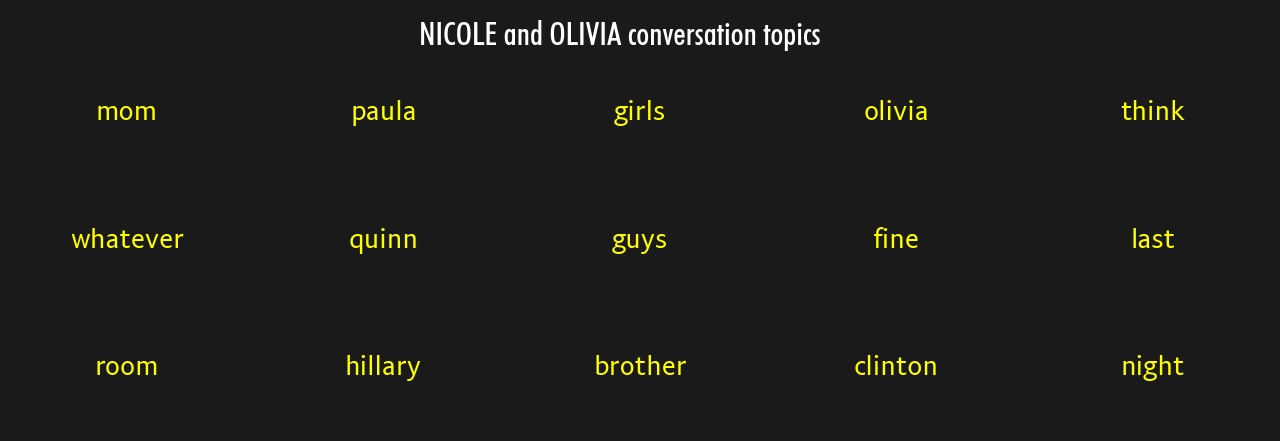

In [8]:
plot_word_grid(NICOLE_df.loc[0, 'topic'], 'NICOLE and OLIVIA conversation topics')

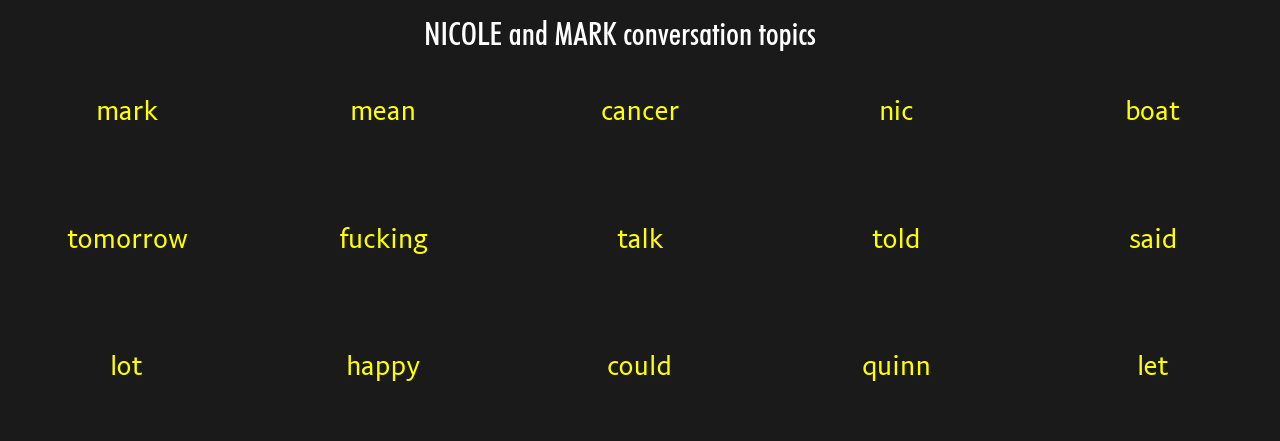

In [9]:
plot_word_grid(NICOLE_df.loc[1, 'topic'], 'NICOLE and MARK conversation topics')

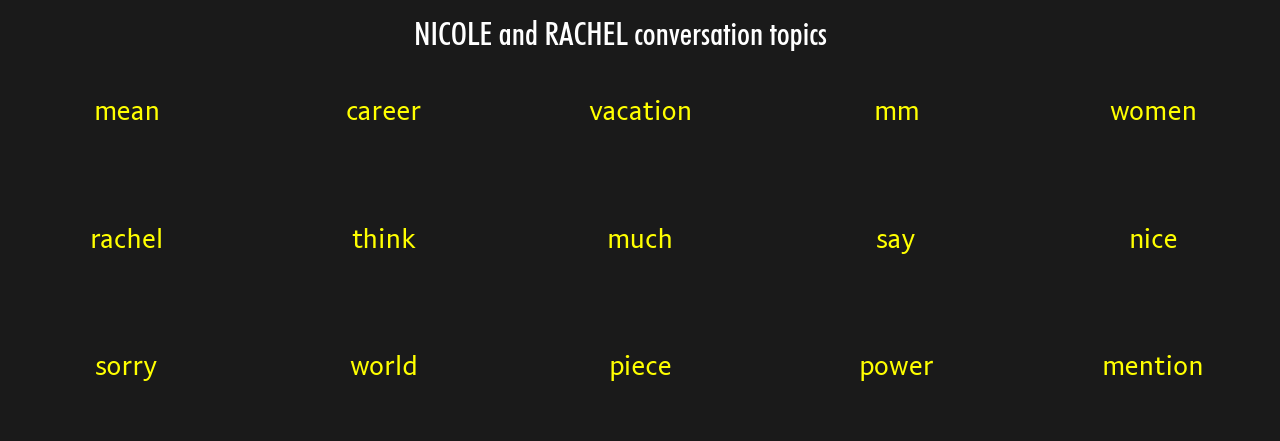

In [10]:
plot_word_grid(NICOLE_df.loc[2, 'topic'], 'NICOLE and RACHEL conversation topics')

### TANYA'S conversations

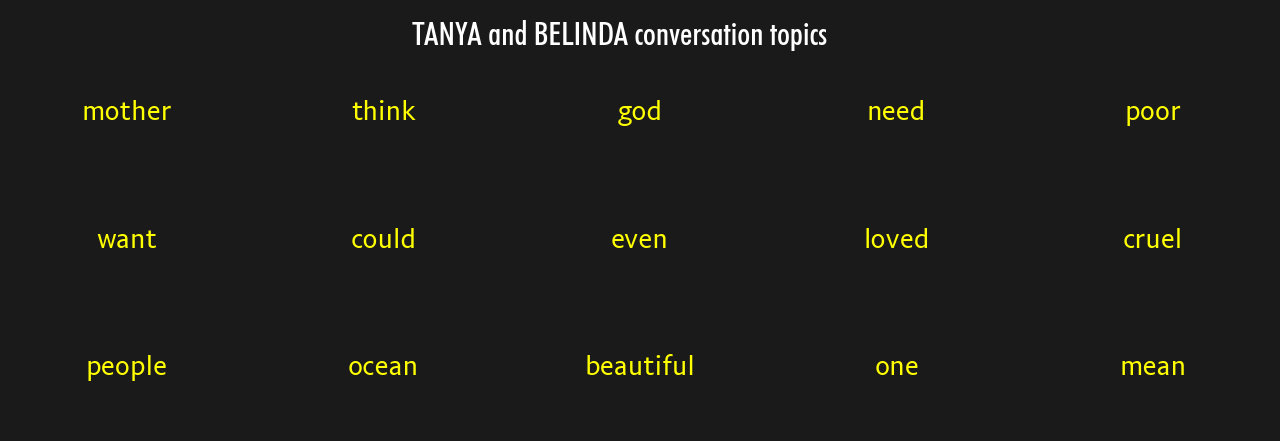

In [11]:
plot_word_grid(TANYA_df.loc[0, 'topic'], 'TANYA and BELINDA conversation topics')

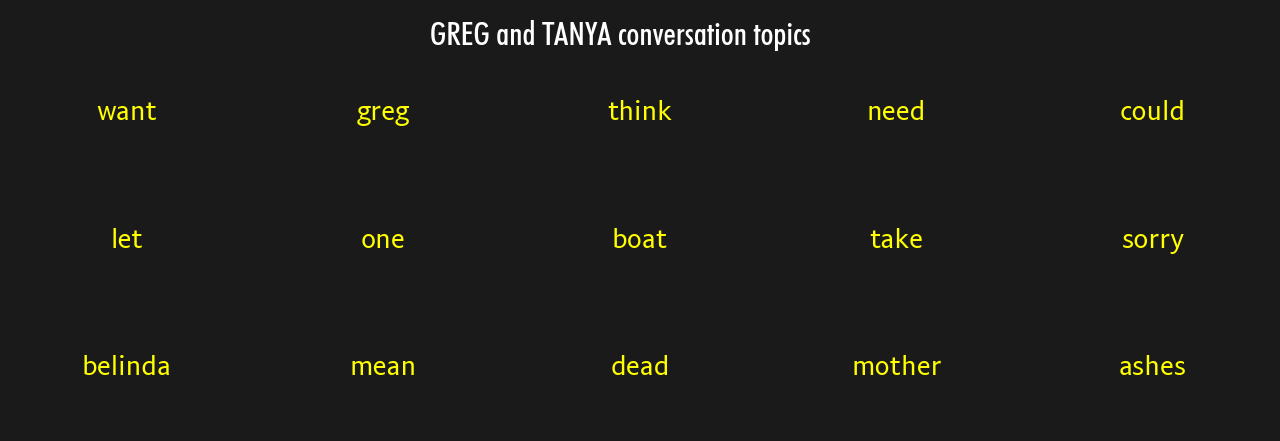

In [12]:
plot_word_grid(TANYA_df.loc[1, 'topic'], 'GREG and TANYA conversation topics')

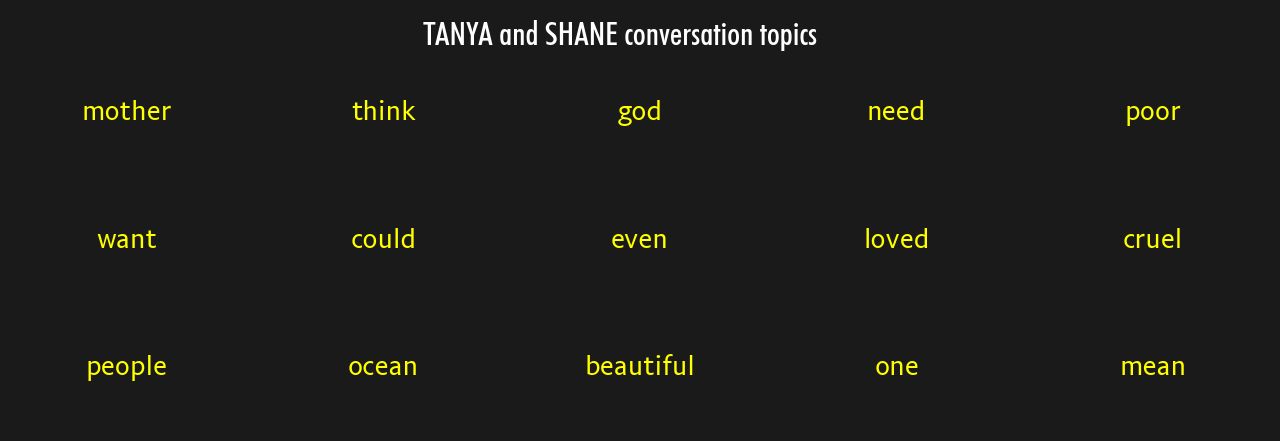

In [13]:
plot_word_grid(TANYA_df.loc[2, 'topic'], 'TANYA and SHANE conversation topics')

### RACHEL'S conversations

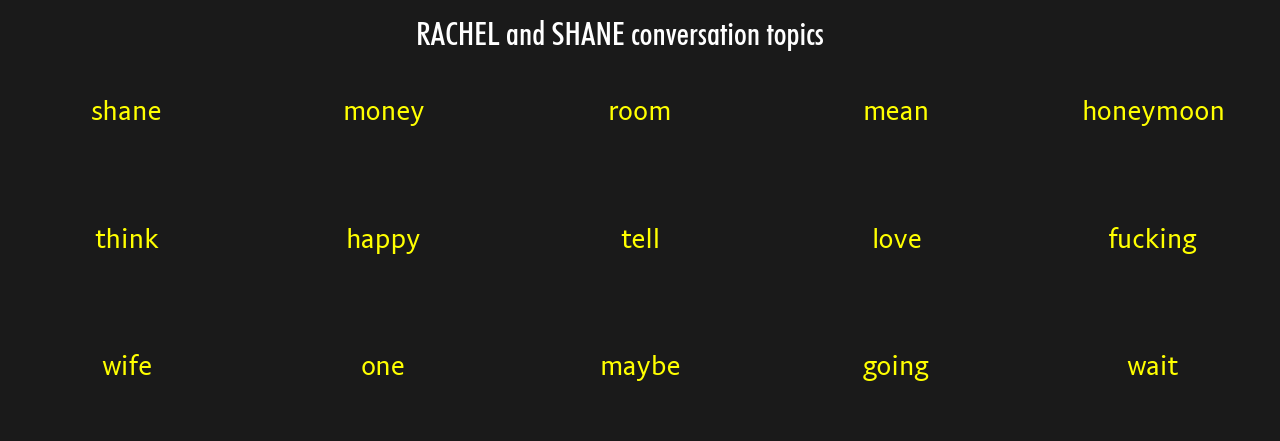

In [14]:
plot_word_grid(RACHEL_df.loc[0, 'topic'], 'RACHEL and SHANE conversation topics')

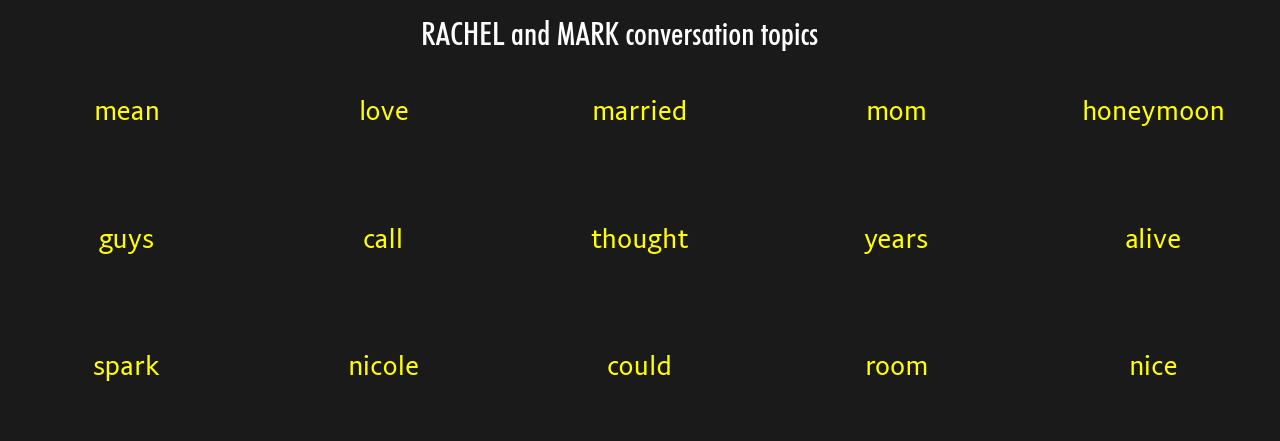

In [15]:
plot_word_grid(RACHEL_df.loc[3, 'topic'], 'RACHEL and MARK conversation topics')

### SHANE'S conversations

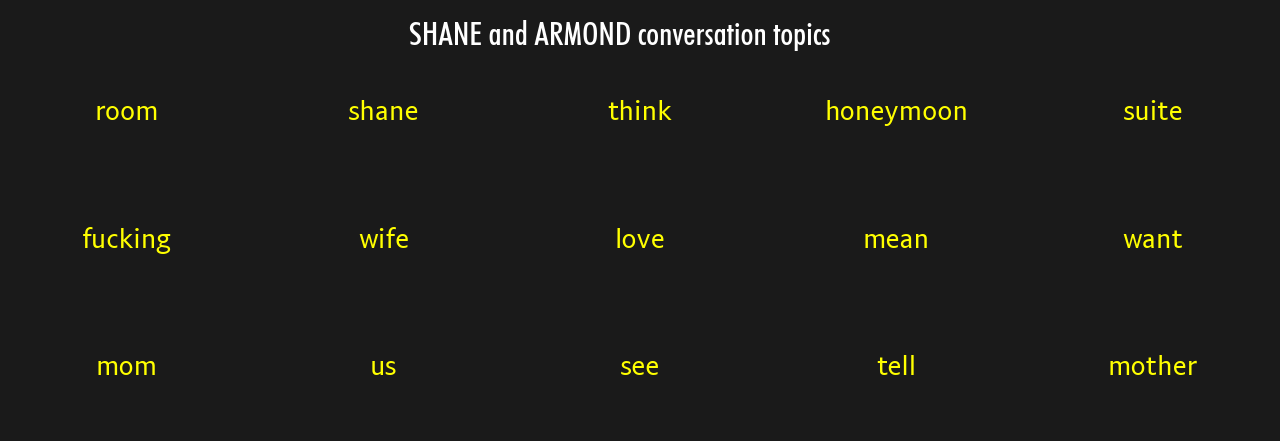

In [16]:
plot_word_grid(SHANE_df.loc[1, 'topic'], 'SHANE and ARMOND conversation topics')

### ARMOND'S conversations

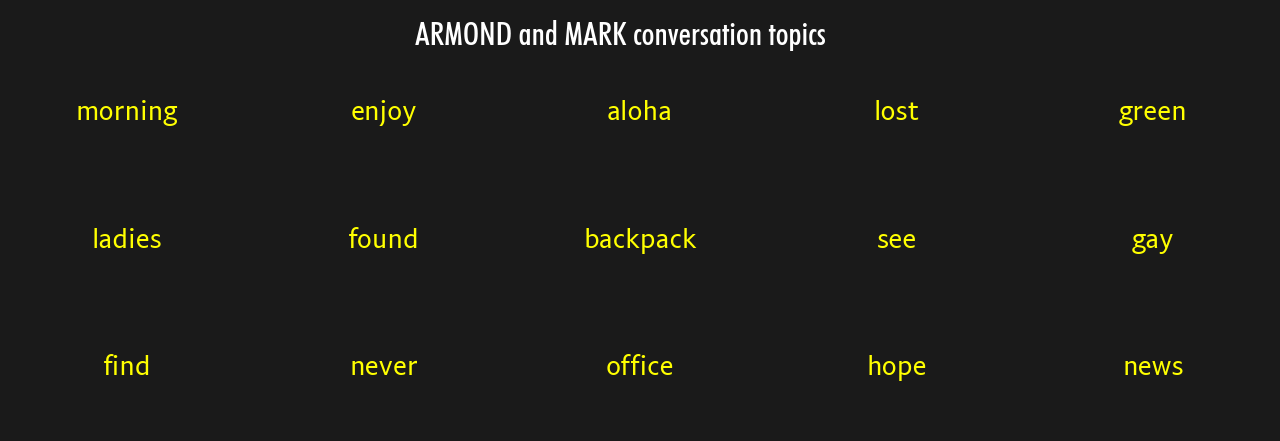

In [17]:
plot_word_grid(ARMOND_df.loc[1, 'topic'], 'ARMOND and MARK conversation topics')

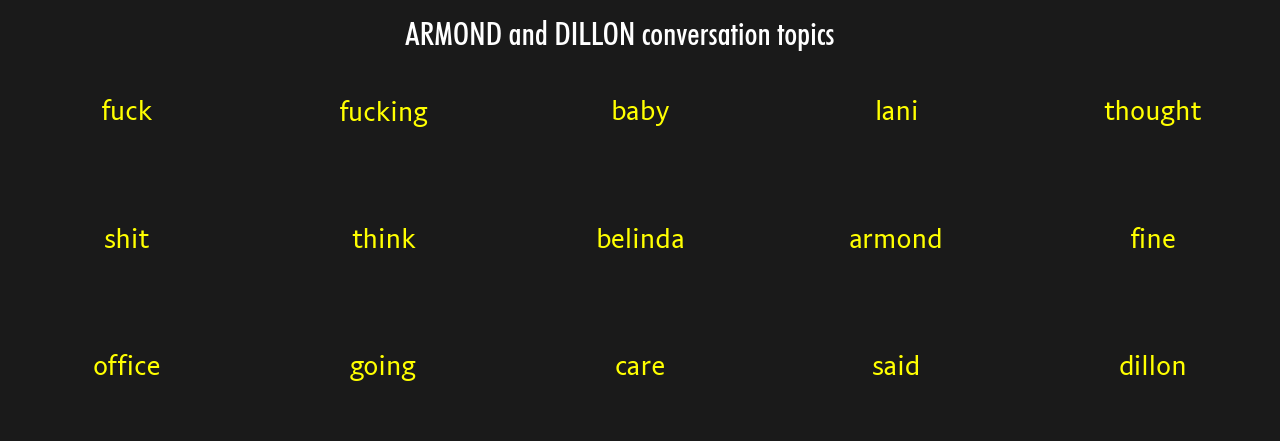

In [18]:
plot_word_grid(ARMOND_df.loc[2, 'topic'], 'ARMOND and DILLON conversation topics')

### PAULA'S conversations

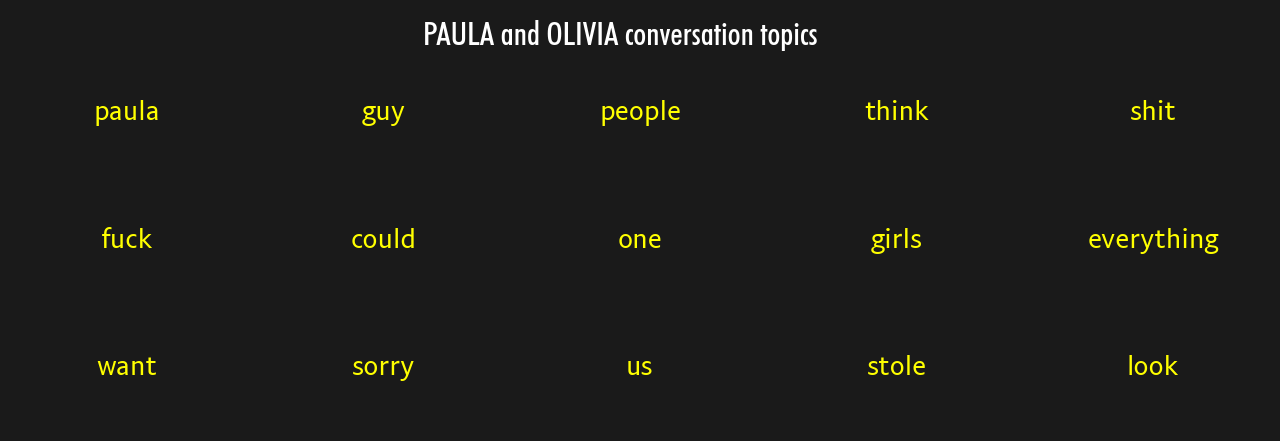

In [19]:
plot_word_grid(PAULA_df.loc[0, 'topic'], 'PAULA and OLIVIA conversation topics')

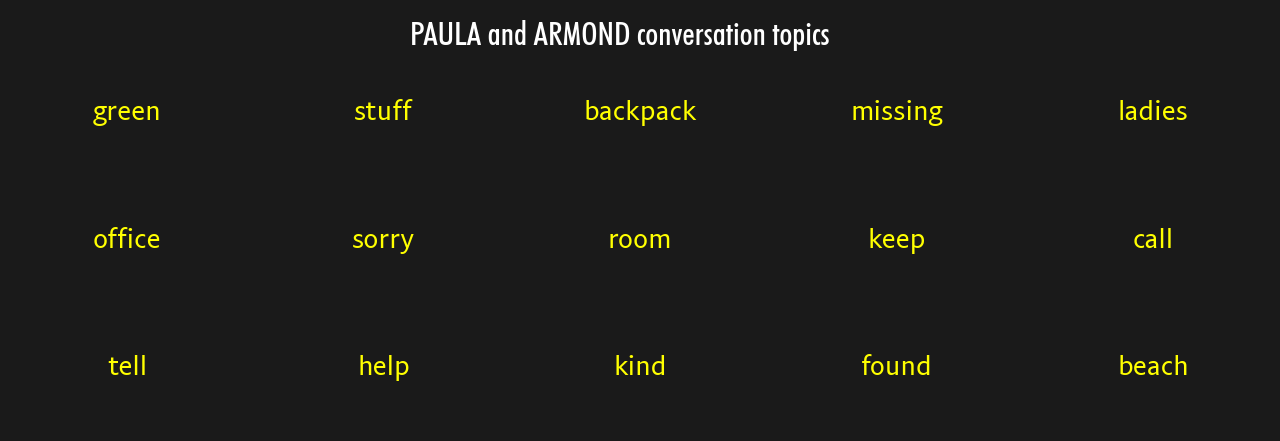

In [20]:
plot_word_grid(PAULA_df.loc[6, 'topic'], 'PAULA and ARMOND conversation topics')

### OLIVIA'S Conversations

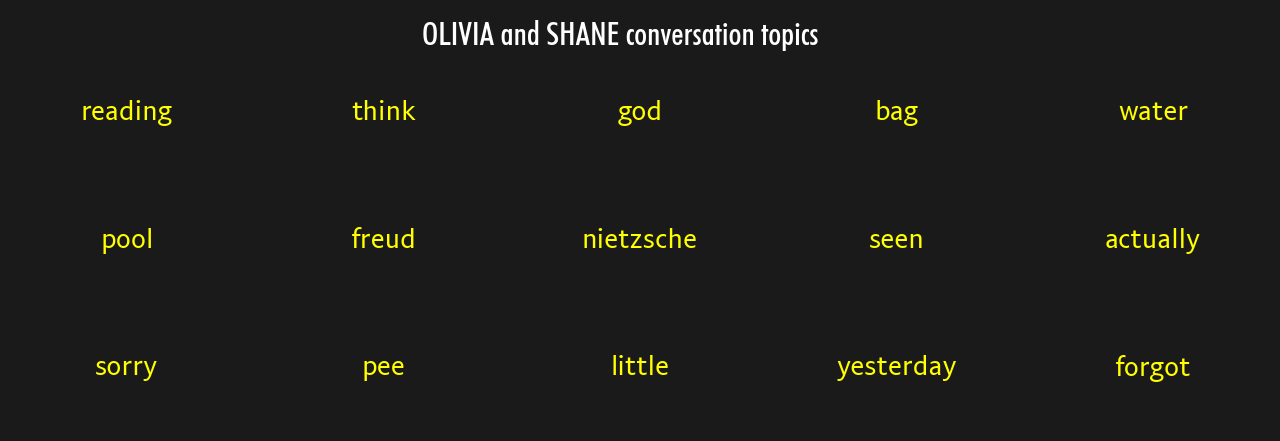

In [21]:
plot_word_grid(OLIVIA_df.loc[7, 'topic'], 'OLIVIA and SHANE conversation topics')

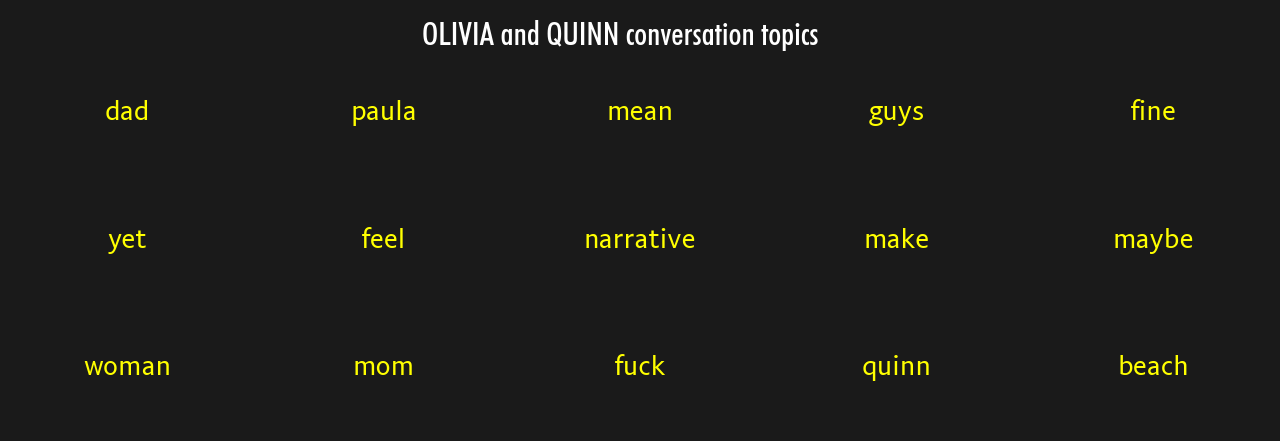

In [22]:
plot_word_grid(OLIVIA_df.loc[6, 'topic'], 'OLIVIA and QUINN conversation topics')